# IDENTIFY TRENDS

In [81]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import mean_squared_error
import re
import math
from scipy.cluster import hierarchy as hc
import scipy
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

## PreProcess

Aggregate all features

In [111]:
product = pd.read_pickle('./datasets/train_labeled_product_series.pkl')
meta = pd.read_pickle('./datasets/train_meta_series.pkl')
dt = pd.merge(left = product, right = meta, left_on = 'date', right_on= 'date')

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


One hot encode categorical variables

In [11]:
dt_dum = pd.get_dummies(dt,columns = ['product_labels', 'weather_index'])

Feature engineering on date

In [7]:
#Helper
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [12]:
add_datepart(dt_dum,'date', drop = False)

## Quick modeling

We will keep a test set out of the cross validation, to be able to compare with the ARIMA. We will use a dedicated time series split in the CV

In [142]:
#helper
def cutoff_date(dt, cutoff):
    date_index = dt.index.get_level_values(level=0)
    return date_index[round(cutoff*len(date_index))-1]
def split_test_train_pers(dt,cutoff):
    cut_date = cutoff_date(dt,cutoff)
    X, Y = dt.drop(['sessions','bookings'], axis = 1), dt.loc[:,['sessions','bookings']]
    lag = datetime.timedelta(days = 1)
    return X.loc[:cut_date,:],Y.loc[:cut_date,:], X.loc[cut_date+lag:,:],Y.loc[cut_date+lag:,:]

### Cross-validate

In [140]:
dt.reset_index()
test = pd.get_dummies(dt,columns = [ 'weather_index'])
add_datepart(test,'date', drop = False)
test = test.set_index(['date','product_labels']).groupby(['date','product_labels']).mean()
Xtr,Ytr,Xtst,Ytst = split_test_train_pers(test,.8)

### Training

In [143]:
rf = RandomForestRegressor(n_estimators = 300,min_samples_leaf = 5)
rf.fit(Xtr,Ytr.sessions)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Interpretation

261.5032491381799


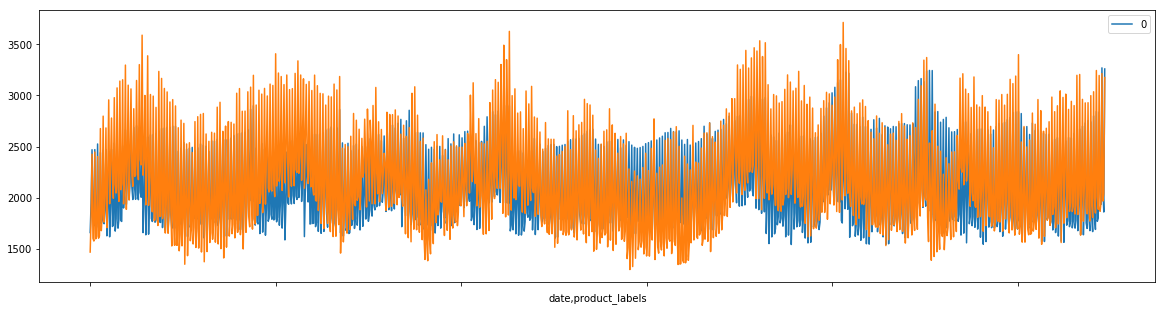

In [144]:
Ypred = rf.predict(Xtst)
print(math.sqrt(mean_squared_error(Ytst.sessions,Ypred)))
b = pd.DataFrame(Ypred, index=Ytst.index).plot(figsize = (20,5))
Ytst.sessions.plot(ax = b)

In [145]:
rf_feat_importance(rf,Xtr).T

,20,0,11,12,3,4,13,1,2,10,...,6,5,7,14,8,15,17,16,18,19
cols,Elapsed,product_id,Day,Dayofweek,online_visibility,tv_ad_reach,Dayofyear,consumer_confidence_index,exchange_rate,Week,...,weather_index_better than average,weather_index_average,weather_index_worse than average,Is_month_end,Year,Is_month_start,Is_quarter_start,Is_quarter_end,Is_year_end,Is_year_start
imp,0.539236,0.257994,0.0565377,0.0270775,0.0258693,0.0251754,0.0231515,0.0153273,0.0137961,0.00917389,...,0.00230099,0.000509287,0.000345669,6.64366e-05,2.60975e-05,1.28203e-05,1.52957e-07,0,0,0


### Quick tuning

In [146]:
corr = np.round(scipy.stats.spearmanr(Xtr).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

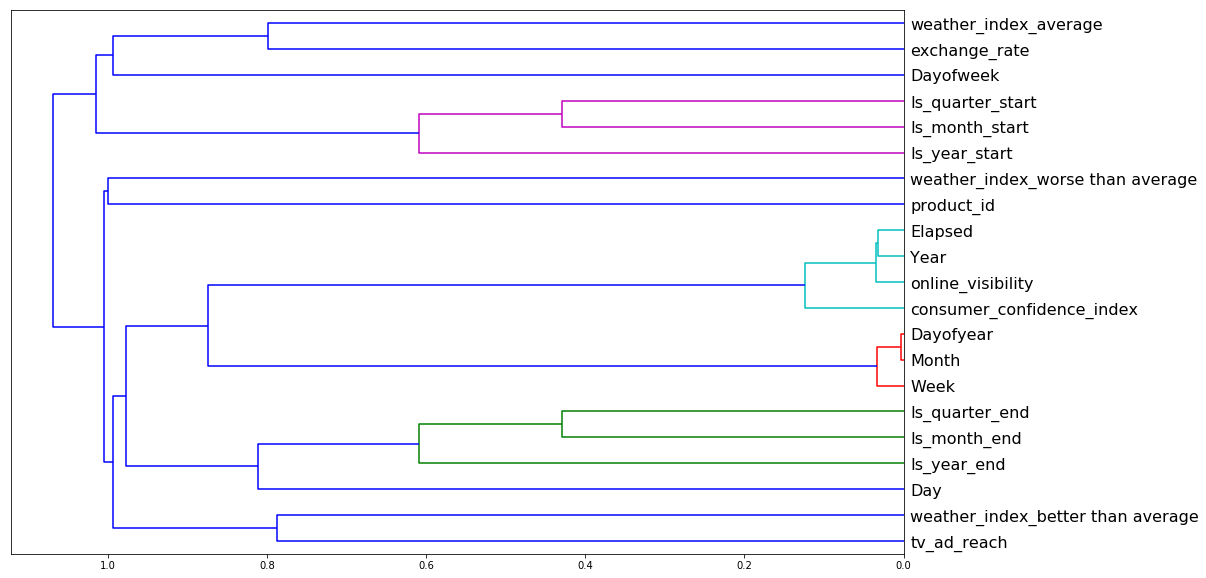

In [148]:
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=Xtr.columns, orientation='left', leaf_font_size=16)
plt.show()

In [156]:
remove = ['Elapsed','Year','online_visibility','consumer_confidence_index',  'Dayofyear','Month', 'Week','Is_quarter_end', 'Is_month_end','Is_quarter_start', 'Is_month_start']
for i in remove:
    rf.fit(Xtr.drop(i,axis = 1),Ytr.sessions)
    Ypr = rf.predict(Xtst.drop(i,axis = 1))
    rmse = math.sqrt(mean_squared_error(Ytst.sessions,Ypr))
    print(f'Removing {i}: {rmse}')

Removing Elapsed: 348.5403220509635
Removing Year: 264.609797216045
Removing online_visibility: 262.15696374679305
Removing consumer_confidence_index: 265.1234077061911
Removing Dayofyear: 242.77457245054302
Removing Month: 263.0178237418026
Removing Week: 260.47487726176576
Removing Is_quarter_end: 264.6643194798031
Removing Is_month_end: 261.20296070585823
Removing Is_quarter_start: 264.7520367118929
Removing Is_month_start: 264.46724077984226


In [162]:
drop_feature = ['Year','Dayofyear','Month', 'Week', 'Is_year_end', 'Is_month_end','Is_year_start', 'Is_month_start']
rf.fit(Xtr.drop(drop_feature, axis=1),Ytr.sessions)
Ypr = rf.predict(Xtst.drop(drop_feature,axis = 1))
rmse = math.sqrt(mean_squared_error(Ytst.sessions,Ypr))
print(f'RMSE: {rmse}')

RMSE: 243.07339658280665


In [166]:
rf_feat_importance(rf,Xtst.drop(drop_feature, axis=1))

,cols,imp
12,Elapsed,5.713767e-01
0,product_id,2.579261e-01
8,Day,5.725971e-02
9,Dayofweek,2.733236e-02
4,tv_ad_reach,2.619887e-02
3,online_visibility,2.545584e-02
1,consumer_confidence_index,1.627755e-02
2,exchange_rate,1.467815e-02
6,weather_index_better than average,2.663050e-03
5,weather_index_average,4.879152e-04


Time variables seems to have the biggest importance.

---------
# UTILS

In [6]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def rmse(y_target,y_predict):
    return math.sqrt(np.mean((y_target-y_predict)**2))